# How does AusEFlux represent the Big Dry, Black Summer, and subseqent triple La Nina?

Are previous fire recoveries well reproduced by AusEFlux? e.g. Canberra fires, Black Saturday fires? Validation data?

Drivers/causes of a bi-modal recovery?

Forecasting recovery? Will there be a slowdown now the La Nina's have passed?

In [1]:
import sys
import folium
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
import numpy as np
import contextily as ctx
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

import odc.geo.xr
# from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

In [2]:
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from dask_utils import start_local_dask

client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 132432686080 due to system memory limit of 32.00 GiB


<Client: 'tcp://127.0.0.1:39119' processes=1 threads=7, memory=32.00 GiB>

## Analysis Parameters

Start with 5km resolution datasets to speed up exploration

In [3]:
er_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_ER_2003_2022_5km_quantiles_v1.1.nc'
gpp_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_GPP_2003_2022_5km_quantiles_v1.1.nc'
nee_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_NEE_2003_2022_5km_quantiles_v1.1.nc'
et_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_ET_2003_2022_5km_quantiles_v1.1.nc'
ndvi_path = '/g/data/os22/chad_tmp/NEE_modelling/data/1km/kNDVI_1km_monthly_2002_2022.nc'
sm_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/S-GRAFS_5km_monthly_2015_2022.nc'
rain_path =  '/g/data/os22/chad_tmp/NEE_modelling/data/1km/rain_1km_monthly_2002_2022.nc'

chunks=dict(latitude=250, longitude=250, time=1)

t_range='2003', '2022'

#SE AUS
lat_bounds = slice(355, 590)
lon_bounds = slice(575,840)

#All of Aus
# lat_bounds = slice(0, 680)
# lon_bounds = slice(0,840)

## Open data

And clip to lat/lon bounds

In [4]:
er = assign_crs(xr.open_dataset(er_path, chunks=chunks)['ER_median'].isel(latitude=lat_bounds, longitude=lon_bounds), crs='EPSG:4326')
gpp = assign_crs(xr.open_dataset(gpp_path, chunks=chunks)['GPP_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')
nee = assign_crs(xr.open_dataset(nee_path, chunks=chunks)['NEE_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')
et = assign_crs(xr.open_dataset(et_path, chunks=chunks)['ET_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')
# sm = assign_crs(xr.open_dataset(sm_path, chunks=chunks)['soil_moisture'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')
# rain = assign_crs(xr.open_dataset(rain_path, chunks=chunks)['rain'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')

er =  round_coords(er)
gpp =  round_coords(gpp)
nee =  round_coords(nee)
et =  round_coords(et)
# sm =  round_coords(sm)
# rain =  round_coords(rain)

In [20]:
# burn = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/FireDisturbance_1km_monthly_2002_2021.nc').sel(time=slice('2019','2020')), crs='EPSG:4326')
# burn = burn.odc.reproject(et.odc.geobox, resampling='average')
# burn =  round_coords(burn)
# burn = burn.sel(time=slice('2019-07', '2020-05'))
# burn = burn.where(burn<40).sum('time')
# burn = burn>0

# xx = gpd.read_file('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NIAFED_20190701_20200622_v20200623.shp')
# xx = xx.to_crs('EPSG:4326')
# poly = gpd.read_file('/g/data/os22/chad_tmp/climate-carbon-interactions/data/poly.geojson')
# xx = gpd.overlay(xx,poly, how='intersection')

burn = gpd.read_file('/g/data/os22/chad_tmp/climate-carbon-interactions/data/BlackSummer_burn_extent_NIAFED.geojson')
burn = xr_rasterize(burn.iloc[[0]], gpp.isel(time=1))
burn = round_coords(burn)

In [21]:
ndvi = assign_crs(xr.open_dataset(ndvi_path, chunks=chunks)['kNDVI'], crs='EPSG:4326')
ndvi = ndvi.odc.reproject(et.odc.geobox, resampling='average')
ndvi =  round_coords(ndvi).compute()

rain = assign_crs(xr.open_dataset(rain_path, chunks=chunks)['rain'], crs='EPSG:4326')
rain = rain.odc.reproject(et.odc.geobox, resampling='average')
rain =  round_coords(rain).compute()

/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python392/lib/python3.9/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


## Plot timeseries

In [ ]:
# fig,ax = plt.subplots(1,1, figsize=(11,4))
# gpp.mean(['latitude','longitude']).compute().plot(ax=ax, label='GPP')
# er.mean(['latitude','longitude']).compute().plot(ax=ax, label='ER')
# # nee.mean(['latitude','longitude']).plot(ax=ax, label='NEE')
# et.mean(['latitude','longitude']).compute().plot(ax=ax, label='ET')

# ax.legend(loc='best', fontsize=14)
# ax.set_ylabel('', fontsize=14)
# ax.set_title('SE Aus carbon and water fluxes');

## Calculate Anomalies

In [22]:
er_clim_mean = er.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()
gpp_clim_mean = gpp.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()
nee_clim_mean = nee.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()
et_clim_mean = et.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()

# sm_clim_mean = sm.sel(time=slice('2015', '2022')).groupby('time.month').mean().compute()
rain_clim_mean = rain.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()
ndvi_clim_mean = ndvi.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()

In [23]:
warnings.filterwarnings("ignore")
er_clim_std = er.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()
gpp_clim_std = gpp.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()
nee_clim_std = nee.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()
et_clim_std = et.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()

# sm_clim_std = sm.sel(time=slice('2015', '2022')).groupby('time.month').std().compute()
ndvi_clim_std = ndvi.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()
rain_clim_std = rain.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()

In [25]:
#standardized anom
def stand_anomalies(ds, clim_mean, clim_std):
    std_anom = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
    ds.compute().groupby("time.month"),
    clim_mean, clim_std)
    return std_anom

er_std_anom = stand_anomalies(er, er_clim_mean, er_clim_std)
gpp_std_anom = stand_anomalies(gpp, gpp_clim_mean, gpp_clim_std)
nee_std_anom = stand_anomalies(nee, nee_clim_mean, nee_clim_std)
et_std_anom = stand_anomalies(et, et_clim_mean, et_clim_std)

# sm_std_anom = stand_anomalies(sm, sm_clim_mean, sm_clim_std)
ndvi_std_anom = stand_anomalies(ndvi, ndvi_clim_mean, ndvi_clim_std)
rain_std_anom = stand_anomalies(rain, rain_clim_mean, rain_clim_std)

In [37]:
# fig,ax = plt.subplots(1,1, figsize=(11,4))
# gpp_std_anom.mean(['latitude','longitude']).plot(ax=ax, label='GPP')
# er_std_anom.mean(['latitude','longitude']).plot(ax=ax, label='ER')
# et_std_anom.mean(['latitude','longitude']).plot(ax=ax, label='ET')
# nee_std_anom.mean(['latitude','longitude']).plot(ax=ax, label='NEE')

# ax.legend(loc='best', fontsize=12)
# ax.set_ylabel('', fontsize=12)
# ax.axhline(0, c='grey')
# ax.set_title('Carbon and water flux standardised anomalies');

## Maps of bushfires in 19-20

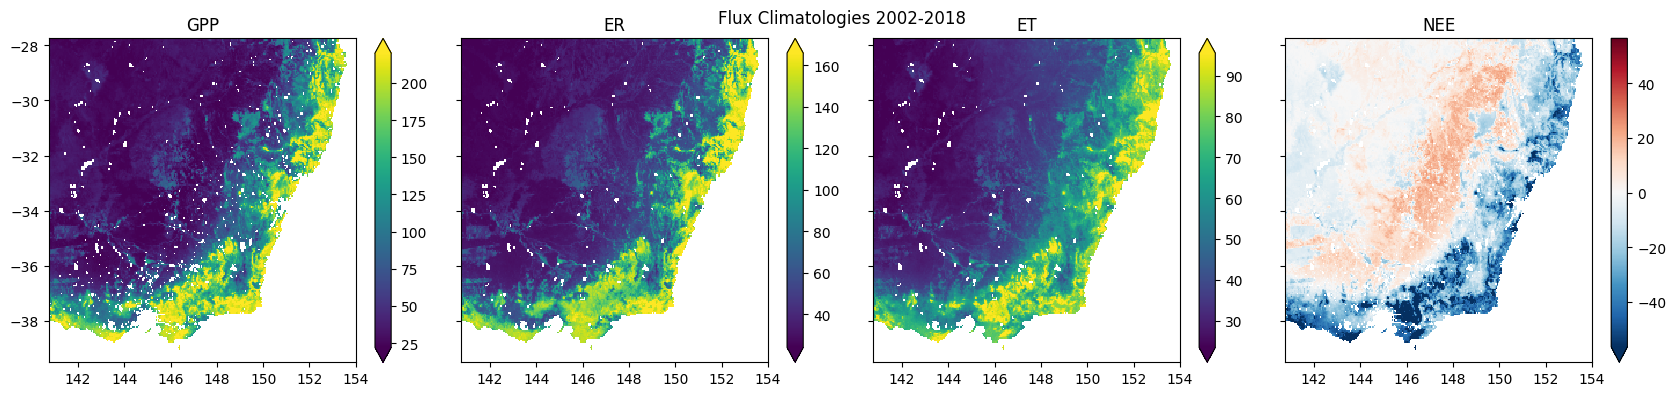

In [27]:
xx = [gpp_clim_mean, er_clim_mean, et_clim_mean, nee_clim_mean]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n in zip(ax.reshape(-1), xx, names): 
    x.sel(month=[10,11,12,1]).mean('month').rename('').plot.imshow(robust=True, ax=a, )
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)
plt.tight_layout()
plt.suptitle('Flux Climatologies 2002-2018 ');

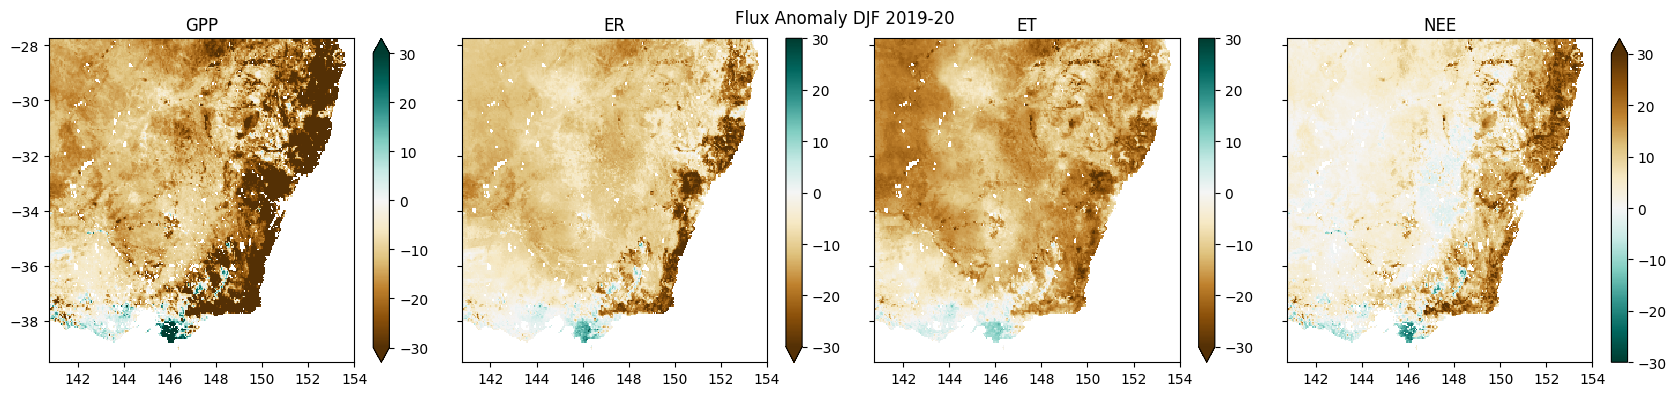

In [28]:
xx = [gpp_anom, er_anom, et_anom, nee_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n, i in zip(ax.reshape(-1), xx, names, range(0,len(xx))): 
    if i==3:
        cmap='BrBG_r'
    else:
        cmap='BrBG'
    x.sel(time=slice('2019-12-01', '2020-02-28')).mean('time').rename('').plot.imshow(ax=a, cmap=cmap, vmin=-30, vmax=30)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)
plt.tight_layout()
plt.suptitle('Flux Anomaly DJF 2019-20');

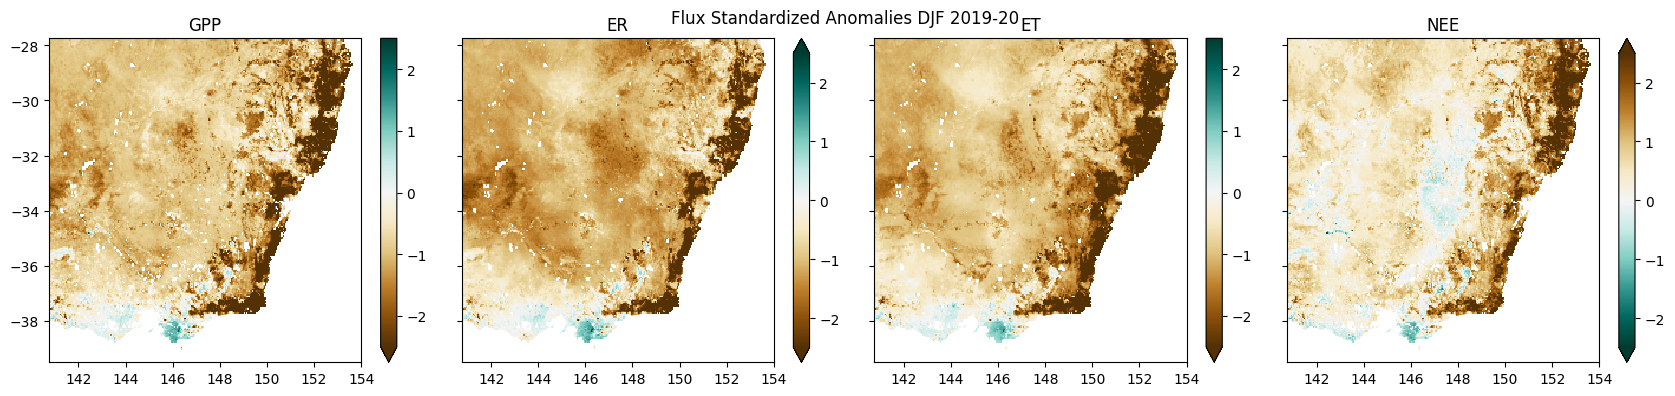

In [29]:
xx = [gpp_std_anom, er_std_anom, et_std_anom, nee_std_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n, i in zip(ax.reshape(-1), xx, names, range(0,len(xx))): 
    if i==3:
        cmap='BrBG_r'
    else:
        cmap='BrBG'
    x.sel(time=slice('2019-12-01', '2020-02-28')).mean('time').rename('').plot.imshow(ax=a, cmap=cmap, vmin=-2.5, vmax=2.5)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)
plt.tight_layout()
plt.suptitle('Flux Standardized Anomalies DJF 2019-20');

## Plot extent on interactive map

In [ ]:
# m = folium.Map(control_scale = True)

# # gpp_trend.where(gpp_trend.p_value<0.1).slope.odc.add_to(m, robust=True, cmap='RdBu')
# assign_crs(nee_std_anom.sel(time=slice('2019-10-01', '2020-01-31')).mean('time'), crs='EPSG:4326').odc.add_to(m, vmin=-2.5, vmax=2.5, cmap='BrBG_r')

# # Zoom map to Australia
# m.fit_bounds(nee_std_anom.odc.map_bounds())

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = True,
#         control = True
#        ).add_to(m)

# folium.LayerControl().add_to(m)
# display(m)

## Per bioclimatic region + aggregate further by vegetation types using National Veg Info System

In [30]:
bio = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.nc'), crs='EPSG:4326')
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

import rioxarray as rxr
ds = rxr.open_rasterio('/g/data/os22/chad_tmp/climate-carbon-interactions/data/aus6_0e_mvg.tif').squeeze().drop('band')

In [31]:
woody = ds.isin([1,2,3,5,6,7,8,9,11,12,13,14])
grass = ds.isin([119,20,21])
shrubs = ds.isin([15,16,17,18,22,32])
crops = ds.isin([25])

In [32]:
woody = woody.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Woodlands')
grass = grass.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Grasses')
shrubs = shrubs.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Shrubs')
crops = crops.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Crops')

woody =  round_coords(woody)
grass =  round_coords(grass)
shrubs =  round_coords(shrubs)
crops =  round_coords(crops)

### Break veg types into bioclimatic regions

In [33]:
bioclim_masks = []
for index, row in gdf.iterrows():    
    mask = xr_rasterize(gdf.iloc[[index]], gpp.isel(time=1))
    mask = mask.rename(row['region_name'])
    bioclim_masks.append(round_coords(mask))

In [34]:
woody_temperate = woody.where((bioclim_masks[3] | bioclim_masks[2])).astype(np.int8).rename('Woody_temperate')
woody_tropics = woody.where(bioclim_masks[0]).astype(np.int8).rename('Woody_tropics')
woody_med = woody.where(bioclim_masks[4]).astype(np.int8).rename('Woody_mediterranean')
woody_semiarid = woody.where((bioclim_masks[1] | bioclim_masks[5])).astype(np.int8).rename('Woody_(semi)arid')

crops_med = crops.where(bioclim_masks[4]).astype(np.int8).rename('Crop_mediterranean')
crops_temp = crops.where((bioclim_masks[3] | bioclim_masks[2])).astype(np.int8).rename('Crop_temperate')

grasses_semiarid = grass.where((bioclim_masks[1] | bioclim_masks[5])).astype(np.int8).rename('Grasses_(semi)arid')

shrubs_semiarid = shrubs.where((bioclim_masks[1] | bioclim_masks[5])).astype(np.int8).rename('Shrubs_(semi)arid')

In [81]:
# masks = [woody_temperate,woody_tropics,woody_med,woody_semiarid,crops_med,crops_temp, grasses_semiarid, shrubs_semiarid]

# fig,ax = plt.subplots(2,4, figsize=(14,6), sharex=True, sharey=True)
# for a,m,n in zip(ax.reshape(-1), masks, [mask.name for mask in masks]): 
#     m.where(m==1).plot(ax=a, add_colorbar=False, add_labels=False, cmap='Wistia')
#     ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
#     a.set_title(n)
# plt.tight_layout();

## Woody temperate not burnt

In [64]:
woody_not_burnt = (woody_temperate - burn)
woody_not_burnt = xr.where(woody_not_burnt==1, 1, 0)

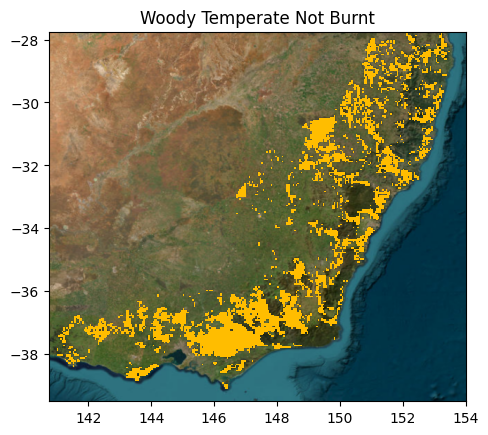

In [102]:
fig,ax = plt.subplots(1,1,sharex=True, sharey=True)
woody_not_burnt.where(woody_not_burnt==1).plot(ax=ax, add_colorbar=False, add_labels=False, cmap='Wistia')
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
ax.set_title('Woody Temperate Not Burnt');

### Convert rainfall dataset into dataframe

In [71]:
rain_df = rain_std_anom.where(burn).rename('rain').sel(time=slice('2017', '2022')).rolling(time=3,
                min_periods=1).mean().mean(['latitude','longitude']).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

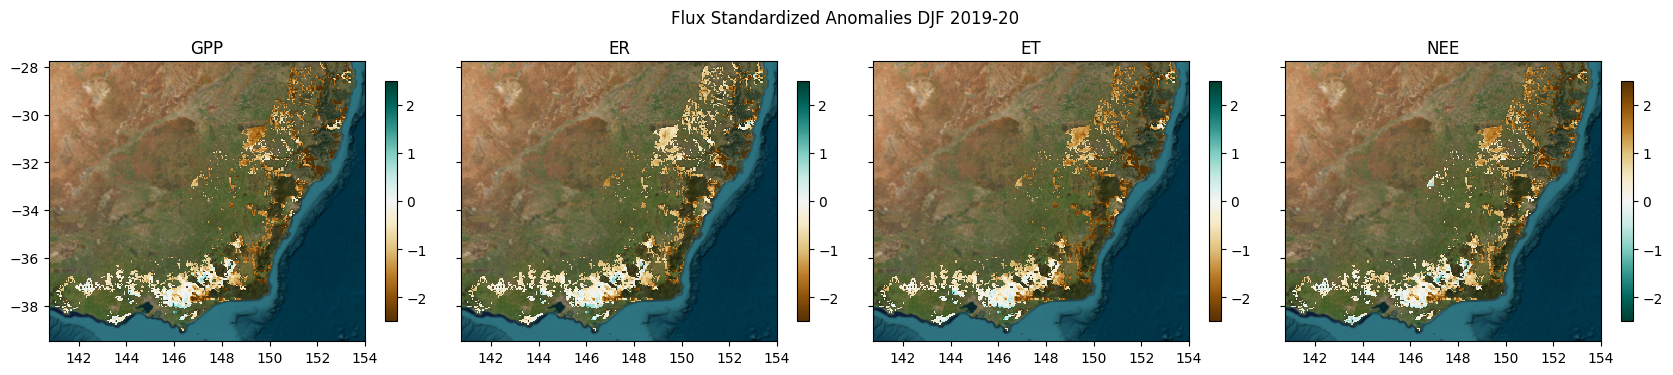

In [68]:
xx = [gpp_std_anom, er_std_anom, et_std_anom, nee_std_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n, i in zip(ax.reshape(-1), xx, names, range(0,len(xx))): 
    if i==3:
        cmap='BrBG_r'
    else:
        cmap='BrBG'
    im = x.sel(time=slice('2019-12-01', '2020-02-28')).mean('time').where(woody_not_burnt).rename('').plot(ax=a, cmap=cmap, vmin=-2.5, vmax=2.5, add_colorbar=False)
    cbar = plt.colorbar(im, ax=a, shrink=0.65)
    ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)

plt.tight_layout()
plt.suptitle('Flux Standardized Anomalies DJF 2019-20');

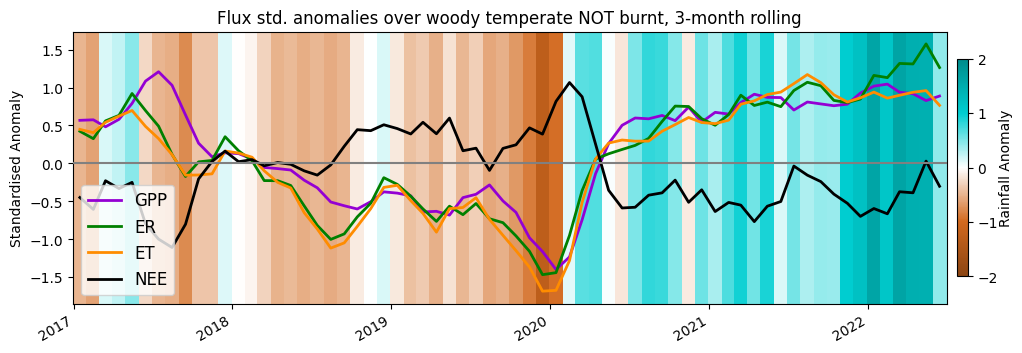

In [73]:
fig,ax = plt.subplots(1,1, figsize=(13,4), zorder=10)
ax2 = ax.twinx() 

gpp_std_anom.where(woody_not_burnt).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='GPP', linewidth=2, c='darkviolet')
er_std_anom.where(woody_not_burnt).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='ER', linewidth=2, c='green')
et_std_anom.where(woody_not_burnt).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='ET', linewidth=2, c='darkorange')
nee_std_anom.where(woody_not_burnt).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='NEE', linewidth=2, c='black')

norm=plt.Normalize(-2,2)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)

# Reformat y-axis label and tick labels
ax.set_ylabel('Standardised Anomaly')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

ax.legend(loc='best', fontsize=12)
ax.axhline(0, c='grey')
ax.set_title('Flux std. anomalies over woody temperate NOT burnt, 3-month rolling');

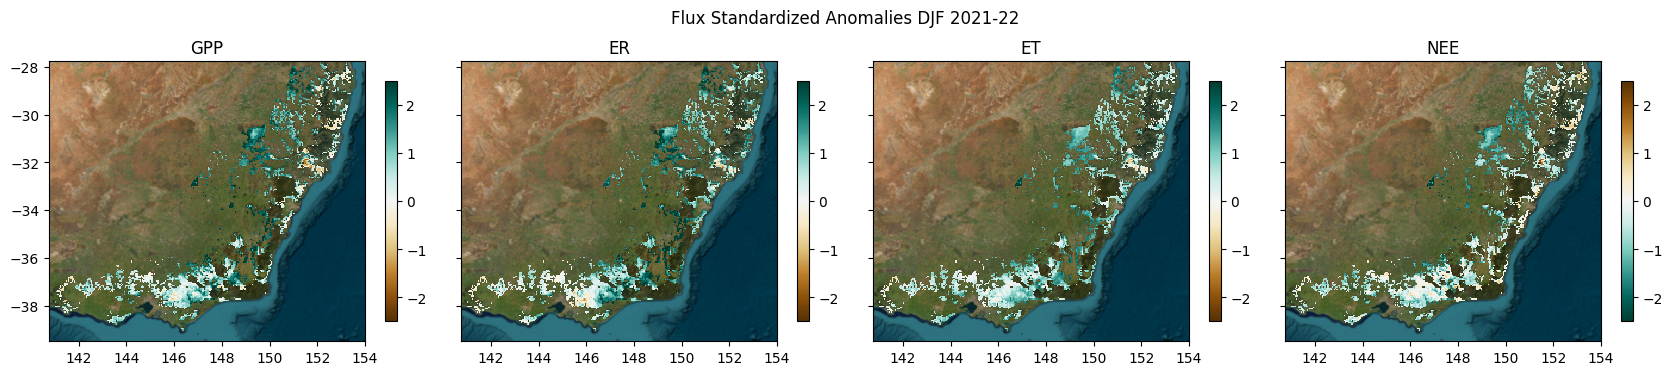

In [70]:
xx = [gpp_std_anom, er_std_anom, et_std_anom, nee_std_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n, i in zip(ax.reshape(-1), xx, names, range(0,len(xx))): 
    if i==3:
        cmap='BrBG_r'
    else:
        cmap='BrBG'
    im = x.sel(time=slice('2021-12-01', '2022-02-28')).mean('time').where(woody_not_burnt).rename('').plot(ax=a, cmap=cmap, vmin=-2.5, vmax=2.5, add_colorbar=False)
    cbar = plt.colorbar(im, ax=a, shrink=0.65)
    ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)

plt.tight_layout()
plt.suptitle('Flux Standardized Anomalies DJF 2021-22');

## Plot burned areas only

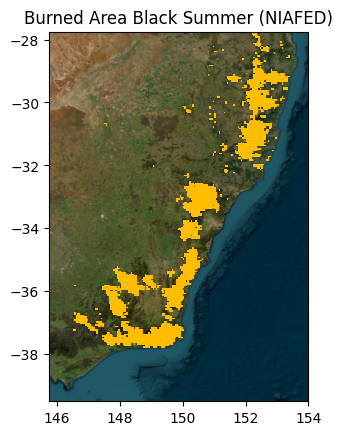

In [118]:
fig,ax = plt.subplots(1,1, sharex=True, sharey=True)
burn.isel(longitude=slice(100,266)).where(burn==True).plot(ax=ax, add_colorbar=False, add_labels=False, cmap='Wistia')
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
ax.set_title('Burned Area Black Summer (NIAFED)');

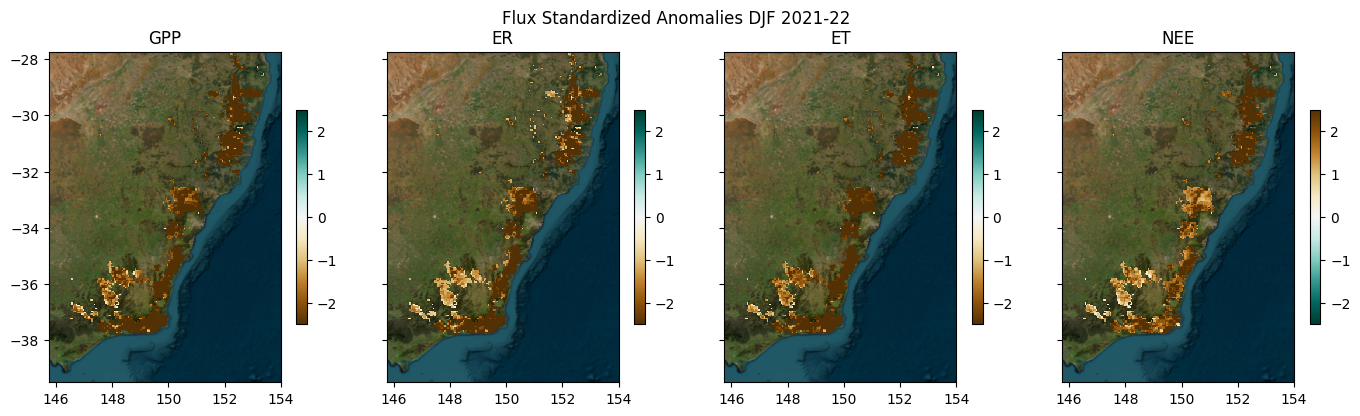

In [99]:
xx = [gpp_std_anom, er_std_anom, et_std_anom, nee_std_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(14,4), sharex=True, sharey=True)
for a, x, n, i in zip(ax.reshape(-1), xx, names, range(0,len(xx))): 
    if i==3:
        cmap='BrBG_r'
    else:
        cmap='BrBG'
    im = x.isel(longitude=slice(100,266)).sel(time=slice('2019-12-01', '2020-02-28')).mean('time').where(burn==True).rename('').plot(ax=a, cmap=cmap, vmin=-2.5, vmax=2.5, add_colorbar=False)
    cbar = plt.colorbar(im, ax=a, shrink=0.65)
    ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)

plt.suptitle('Flux Standardized Anomalies DJF 2021-22')
plt.tight_layout();

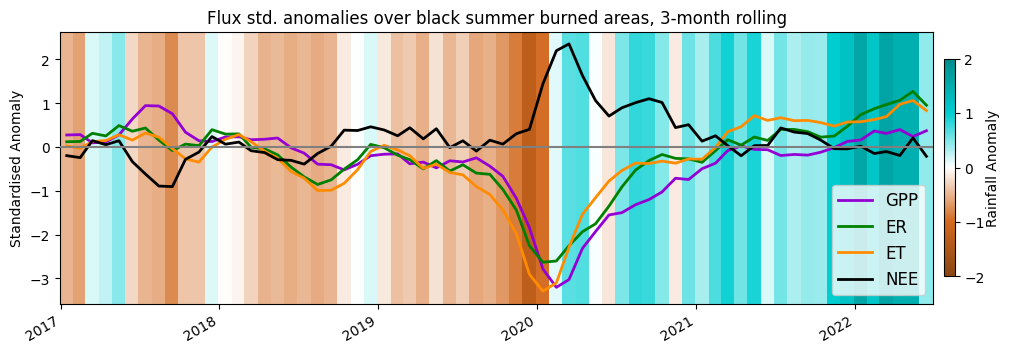

In [85]:
fig,ax = plt.subplots(1,1, figsize=(13,4), zorder=10)
ax2 = ax.twinx() 

gpp_std_anom.where(burn).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='GPP', linewidth=2, c='darkviolet')
er_std_anom.where(burn).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='ER', linewidth=2, c='green')
et_std_anom.where(burn).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='ET', linewidth=2, c='darkorange')
nee_std_anom.where(burn).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='NEE', linewidth=2, c='black')
# ndvi_std_anom.where(burn).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='NDVI', linewidth=2, c='red')

norm=plt.Normalize(-2,2)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)

# Reformat y-axis label and tick labels
ax.set_ylabel('Standardised Anomaly')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

ax.legend(loc='best', fontsize=12)
ax.axhline(0, c='grey')
ax.set_title('Flux std. anomalies over black summer burned areas, 3-month rolling');

## Other Products

In [88]:
modis_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/MODIS_GPP_1km_monthly_2002_2021.nc')
modis_gpp.attrs['nodata'] = np.nan

gosif_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')
gosif_gpp.attrs['nodata'] = np.nan

# grid = zoom_out(ds.odc.geobox, 5)
modis_gpp = modis_gpp.chunk(dict(latitude=1000,longitude=1000, time=1)).odc.reproject(how=gpp.odc.geobox,
                      resampling='average').compute()

modis_gpp = modis_gpp * 1000
modis_gpp = round_coords(modis_gpp)

gosif_gpp = gosif_gpp.chunk(dict(latitude=1000,longitude=1000, time=1)).odc.reproject(how=gpp.odc.geobox,
                      resampling='bilinear').compute()
gosif_gpp = round_coords(gosif_gpp)


In [96]:
modis_clim_mean = modis_gpp.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()
modis_clim_std = modis_gpp.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()
modis_std_anom = stand_anomalies(modis_gpp, modis_clim_mean, modis_clim_std)

gosif_clim_mean = gosif_gpp.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()
gosif_clim_std = gosif_gpp.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()
gosif_std_anom = stand_anomalies(gosif_gpp, gosif_clim_mean, gosif_clim_std)

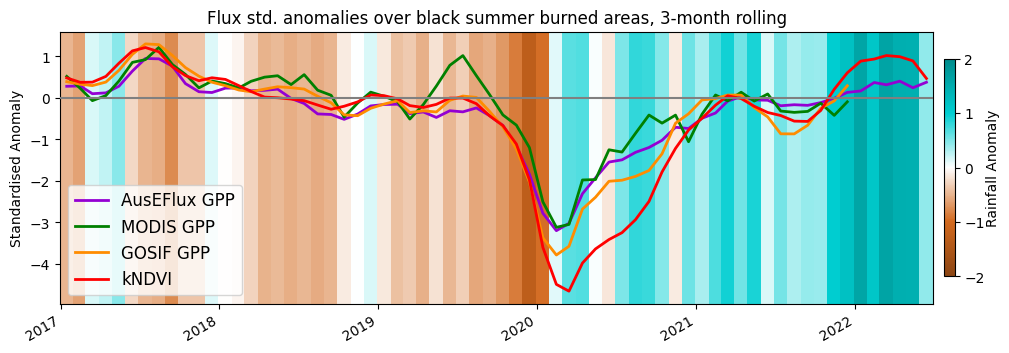

In [98]:
fig,ax = plt.subplots(1,1, figsize=(13,4), zorder=10)
ax2 = ax.twinx() 

gpp_std_anom.where(burn).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='AusEFlux GPP', linewidth=2, c='darkviolet')
modis_std_anom.where(burn).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='MODIS GPP', linewidth=2, c='green')
gosif_std_anom.where(burn).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='GOSIF GPP', linewidth=2, c='darkorange')
ndvi_std_anom.where(burn).sel(time=slice('2017', '2022')).rolling(time=3, min_periods=1).mean().mean(['latitude','longitude']).plot(ax=ax, label='kNDVI', linewidth=2, c='red')

norm=plt.Normalize(-2,2)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)

# Reformat y-axis label and tick labels
ax.set_ylabel('Standardised Anomaly')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

ax.legend(loc='best', fontsize=12)
ax.axhline(0, c='grey')
ax.set_title('Flux std. anomalies over black summer burned areas, 3-month rolling');

## Per pixel time-to-recover

In [113]:
xx = [gpp_std_anom, er_std_anom, et_std_anom, nee_std_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

In [114]:
aa=[]
for ds, n in zip(xx, names):
    beginning = ds.where(burn).sel(time=slice('2020-01', '2022')).rolling(time=3, min_periods=1).mean()
    
    days_in_month = ds.sel(time=slice('2020-01', '2022')).time.dt.days_in_month
    days_in_month = days_in_month.expand_dims(dim={"latitude": ds.latitude, "longitude":ds.longitude})
    
    if n=='NEE':
        count = xr.where(beginning>=0.25, 1, 0)
    else:
        count = xr.where(beginning<=-.25, 1, 0)
    ttr = count*days_in_month
    ttr = ttr.sum('time')
    ttr = ttr.rename(n+'_days-to-recover')
    aa.append(ttr)

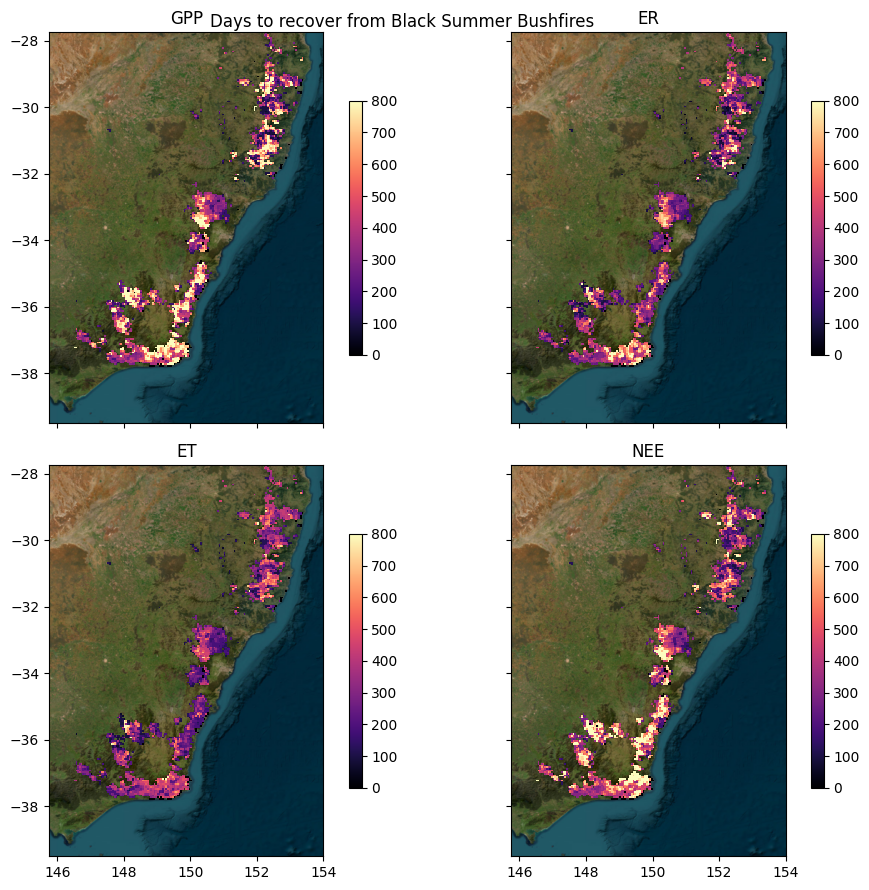

In [115]:
cmap='magma'
vmin=0
fig,ax = plt.subplots(2,2, figsize=(10,9), sharex=True, sharey=True)
for a, x, n in zip(ax.reshape(-1), aa, names): 
    im = x.isel(longitude=slice(100,266)).where(burn==True).rename('').plot(ax=a, cmap=cmap, add_colorbar=False, vmin=0, vmax=900)
    cbar = plt.colorbar(im, ax=a, shrink=0.65)
    ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)
plt.tight_layout()
plt.suptitle('Days to recover from Black Summer Bushfires');

### Histograms

In [116]:
bb = []
for a,n in zip(aa, names):
    df = a.where(a>0).rename(n).drop('spatial_ref').to_dataframe().reset_index(drop=True)
    bb.append(df)
df = pd.concat(bb)

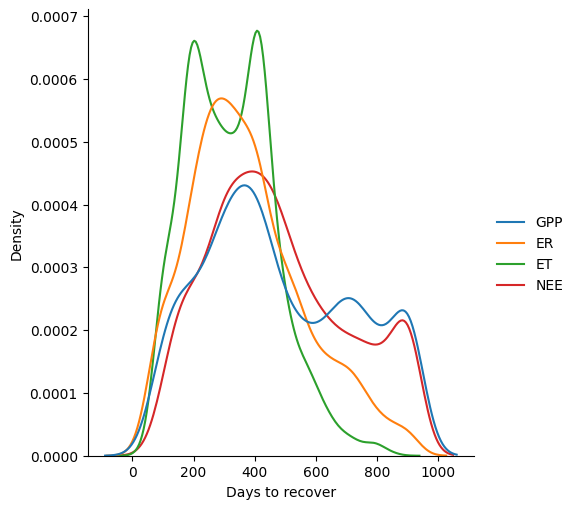

In [117]:
sb.displot(df, kind="kde")
plt.xlabel('Days to recover', fontsize=10);